In [2]:
import numpy as np
import pickle

from numpy.random import seed
seed(1)
import tensorflow as tf


def acoplarMatricesenDia(matricesparaAcoplar, dias):
    numeroMatrices = len(matricesparaAcoplar)
    rows_columns = len(matricesparaAcoplar[0])
    matricesAcopladas = []
    matrizTemporal = np.zeros(shape=(rows_columns, rows_columns))
    for i in range(numeroMatrices-dias):
        for j in range(dias):
            matrizTemporal += matricesparaAcoplar[i+j]
        matricesAcopladas.append(matrizTemporal)
        matrizTemporal = np.zeros(shape=(rows_columns, rows_columns))
    return matricesAcopladas

def acoplarDias(diasparaAcoplar, dias):
    numeroDias = len(diasparaAcoplar)
    diasAcoplados = []
    acopladorTemporal = ""
    for i in range(numeroDias-dias):
        for j in range(dias):
            acopladorTemporal += " "+ diasparaAcoplar[i+j]
        diasAcoplados.append(acopladorTemporal)
        acopladorTemporal = ""
    return diasAcoplados

def createSetBFF_toX(Matrices, Days, twdaysbefore, twdaysafter):
    X = []
    Y = []
    XD = []
    YD = []
    n_matrix = len(Matrices)
    for i in range(n_matrix):
        if (i<n_matrix-twdaysbefore-twdaysafter):
            XD.append([])
            YD.append([])
            for j in range(twdaysbefore):
                X.append(Matrices[i + j])
                XD[i].append(Days[i + j])
            for j in range(twdaysafter):
                Y.append(Matrices[i + twdaysbefore + j])
                YD[i].append(Days[i + twdaysbefore + j])
    return (X, XD, Y, YD)

def createTrainingTest(Matrices, Days, percentage, daysBefore, daysAfter):
    rows_columns = Matrices[0].shape[0]
    division = round(len(Matrices) * percentage)
    training = Matrices[:division]
    test = Matrices[division:]
    dtr = Days[:division]
    dte = Days[division:]
    X_training, XD_training, Y_training, YD_training = createSetBFF_toX(training, dtr, daysBefore, daysAfter)
    X_test, XD_test, Y_test, YD_test = createSetBFF_toX(test, dte, daysBefore, daysAfter)
    X_training = np.array(X_training).reshape(-1,daysBefore,rows_columns,rows_columns, 1)
    Y_training = np.array(Y_training).reshape(-1,rows_columns * rows_columns)
    X_test = np.array(X_test).reshape(-1,daysBefore,rows_columns,rows_columns, 1)
    Y_test = np.array(Y_test).reshape(-1,rows_columns * rows_columns)
    return (X_training, XD_training, Y_training, YD_training, X_test, XD_test, Y_test,  YD_test)

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, SimpleRNN
from tensorflow.keras.optimizers import Adam

def createCLSTM(features, labels, n_convolutions = 16, kernel_conv = 2, kernel_pool = 2, lstm_size = 2, output = 'sigmoid'):
    tf.random.set_seed(4)
    input_nn = Input(features.shape[1:])
    conv1 = TimeDistributed(Conv2D(n_convolutions, (kernel_conv,kernel_conv), padding = 'same', activation='linear'))(input_nn)
    maxp1 = TimeDistributed(MaxPooling2D((kernel_pool, kernel_pool), padding='same'))(conv1)
    flatt1 = TimeDistributed(Flatten())(maxp1)
    lstm1 = LSTM(lstm_size, activation='linear', return_sequences=False)(flatt1)
    output_nn = Dense(labels.shape[1], activation=output)(lstm1)    
    CLSTM = Model(inputs=input_nn, outputs=output_nn)
    #CLSTM.summary()
    return CLSTM

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, roc_curve, precision_recall_curve, auc

def makeBinaryMetric(expected, predicted, setName=' ', debug = True, savefigure = False, filename = ''):
    f_pred = predicted.flatten()
    f_real = expected.flatten()
    i = 0.5
    best_acc = 0
    p = np.copy(f_pred)
    r = np.copy(f_real)
    p[p>=round(i,1)] = 1
    p[p<round(i,1)] = 0
    acc = accuracy_score(r, p)
    if(acc > best_acc):
        best_acc = acc
        best_p = np.copy(p)
        best_r = np.copy(r)
        best_i = round(i,1)
    fpr, tpr, threshold = roc_curve(best_r, best_p)
    precision, recall, thresholds = precision_recall_curve(best_r, best_p)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall, precision)
    if debug:
        if savefigure:
            plot_ROC(fpr, tpr, roc_auc, setName, savefigure, filename)
            plot_PR(recall, precision, pr_auc, setName, savefigure, filename)
        else:
            plot_ROC(fpr, tpr, roc_auc, setName)
            plot_PR(recall, precision, pr_auc, setName)
    return (best_acc, roc_auc, pr_auc, best_p, best_r, best_i)

def plot_ROC(fpr, tpr, roc_auc, setName, savefigure = False, filename = ''):
    f = plt.figure()
    plt.title('Receiver Operating Characteristic {}'.format(setName))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.plot([0, 1], [0, 1],'r--', label = 'Low performance')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.plot(fpr, tpr, 'tab:red', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.tight_layout()
    if savefigure:
        f.savefig('reports/roc_auc_{}.pdf'.format(filename), bbox_inches='tight')
    plt.show()

def plot_PR(recall, precision, pr_auc, setName, savefigure = False, filename = ''):
    f = plt.figure()
    plt.title('Precision-Recall {}'.format(setName))
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.plot([0, 1], [0.1, 0.1],'r--', label = 'Low performance')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.plot(recall, precision, 'tab:red', label = 'AUC = %0.4f' % pr_auc)
    plt.legend(loc = 'lower left')
    plt.tight_layout()
    if savefigure:
        f.savefig('reports/pr_auc_{}.pdf'.format(filename), bbox_inches='tight')
    plt.show()

In [4]:
#Se filtra desde 2016 hasta 2018
with open('../../data/ALLDAYS.pickle', 'rb') as f:
    ALLDAYS = pickle.load(f)
with open('../../data/MB8_ROBBERYSTREET.pickle', 'rb') as f:
    MB8_ROBBERYSTREET = pickle.load(f)
with open('../../data/MB8_LARCENY.pickle', 'rb') as f:
    MB8_LARCENY = pickle.load(f)    

MB8_ROBBERYSTREET = MB8_ROBBERYSTREET[365*2:((365*5)+1)]
MB8_LARCENY = MB8_LARCENY[365*2:((365*5)+1)]
ALLDAYS = ALLDAYS[365*2:((365*5)+1)]

MB8_ROBBERYSTREET = np.array(MB8_ROBBERYSTREET)
MB8_LARCENY = np.array(MB8_LARCENY)

In [5]:
inputsRedes_Larceny = []
inputsRedes_RobberyStreet = []
inputsRedes_Dias =[]
for dia in range(1,6):
    inputsRedes_Larceny.append(acoplarMatricesenDia(MB8_LARCENY, dia))
    inputsRedes_RobberyStreet.append(acoplarMatricesenDia(MB8_ROBBERYSTREET, dia))
    inputsRedes_Dias.append(acoplarDias(ALLDAYS,dia))

In [6]:
def plot_LOSS(history, setName=' ', savefigure = False, filename = ''):
    f = plt.figure()
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title(f'Loss {setName}')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Training', 'Testing'], loc='upper right')
    plt.tight_layout()
    if savefigure:
        f.savefig(f'reports/loss_{filename}.pdf', bbox_inches='tight')
    plt.show()

import json
def MakeFiguresofOneModel(Model_creator, Model_Name, inputRed, inputDias):
    x_tr, xd_tr, y_tr, yd_tr, x_te, xd_te, y_te, yd_te = createTrainingTest(inputRed, inputDias, 0.7, 5, 1)
    y_tr[y_tr >= 1] = 1
    y_te[y_te >= 1] = 1
    model = Model_creator(x_tr,y_tr)
    model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False),metrics=['BinaryAccuracy'])
    epochs = 100 
    batch_size = 32
    history = model.fit(x_tr, y_tr, batch_size=batch_size, epochs=epochs, verbose=0,validation_data=(x_te, y_te))
    plot_LOSS(history, Model_Name.replace("_", " "), True, Model_Name)
    
    # serialize model to JSON
    #model_json = model.to_json()
    #with open(f'../data/FiguresPaper/M_{Model_Name}.json', "w") as json_file:
    #    json_file.write(model_json)
    # serialize weights to HDF5
    #model.save_weights(f"../data/FiguresPaper/modelWeights_{Model_Name}.h5")
    
    dg_tr = model.predict(x_tr)
    dg_te = model.predict(x_te)

    #history_dict = history.history
    #json.dump(history_dict, open(f'../data/FiguresPaper/H_{Model_Name}.json', 'w'))
    
    best_acc, roc_auc, pr_auc, best_ptr, best_rtr, best_i = makeBinaryMetric(y_tr, dg_tr, Model_Name.replace("_", " "), True, True, Model_Name+'_Training')
    print('Training -> Accuracy = {}, Roc_auc = {}, Pr_auc = {}, b_i = {}'.format(best_acc, roc_auc, pr_auc,best_i))
    best_acc, roc_auc, pr_auc, best_pte, best_rte, best_i = makeBinaryMetric(y_te, dg_te, Model_Name.replace("_", " "), True, True, Model_Name+'_Testing')
    print('Test -> Accuracy = {}, Roc_auc = {}, Pr_auc = {}, b_i = {} \n'.format(best_acc, roc_auc, pr_auc,best_i))

Larceny


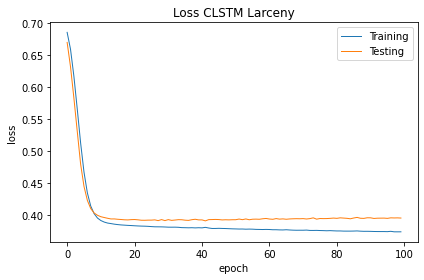

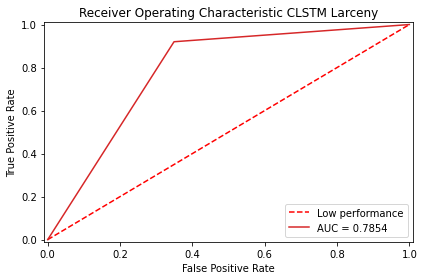

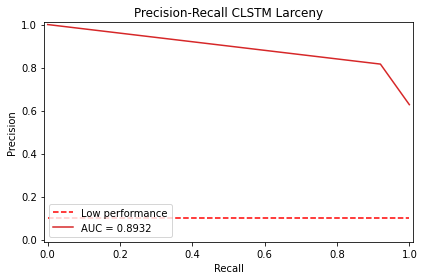

Training -> Accuracy = 0.8197559366754618, Roc_auc = 0.78535672512068, Pr_auc = 0.8932065814883208, b_i = 0.5


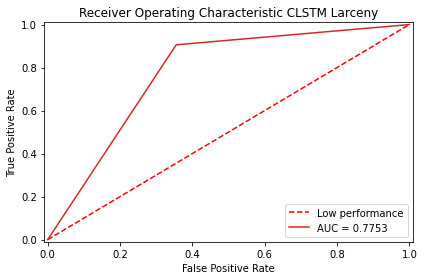

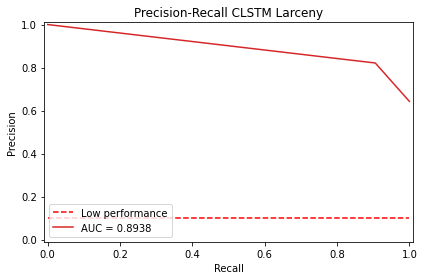

Test -> Accuracy = 0.8126460280373832, Roc_auc = 0.7752549816933454, Pr_auc = 0.8938301457610792, b_i = 0.5 



In [7]:
print('Larceny')
MakeFiguresofOneModel(createCLSTM, 'CLSTM_Larceny', inputsRedes_Larceny[4], inputsRedes_Dias[4])

Robbery Street


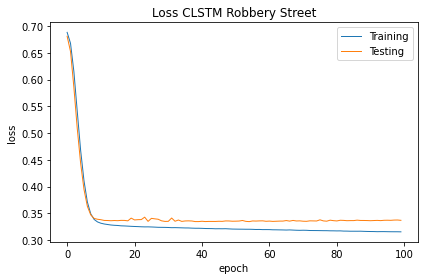

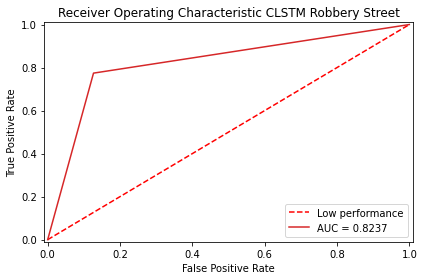

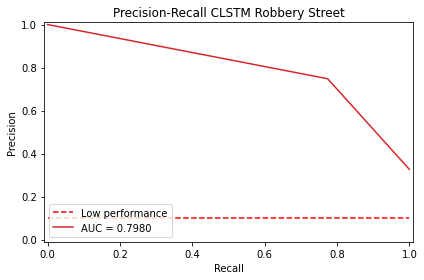

Training -> Accuracy = 0.8408847295514512, Roc_auc = 0.823734216351745, Pr_auc = 0.7980481689364226, b_i = 0.5


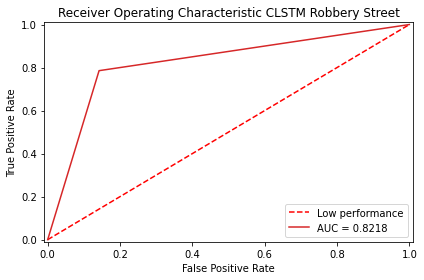

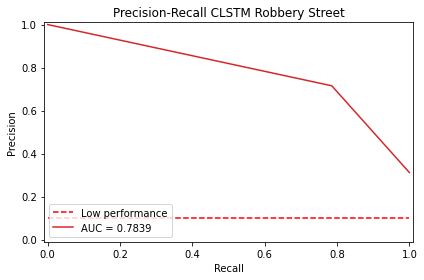

Test -> Accuracy = 0.8353290498442367, Roc_auc = 0.8217622773306721, Pr_auc = 0.78392997383884, b_i = 0.5 



In [8]:
print('Robbery Street')
MakeFiguresofOneModel(createCLSTM, 'CLSTM_Robbery_Street', inputsRedes_RobberyStreet[4], inputsRedes_Dias[4])